Ben Steves, HW9, CS344, March 24 2022

# Tutorial 1: Loading Audio Data

In [1]:
import torch
import torchaudio

In [2]:
yesno_data = torchaudio.datasets.YESNO('./', download=True)

# Pick data point number 3 to see an example of the the yesno_data:
n = 3
waveform, sample_rate, labels = yesno_data[n]
print("Waveform: {}\nSample rate: {}\nLabels: {}".format(waveform, sample_rate, labels))

Waveform: tensor([[ 3.0518e-05,  6.1035e-05,  3.0518e-05,  ..., -1.8311e-04,
          4.2725e-04,  6.7139e-04]])
Sample rate: 8000
Labels: [0, 0, 1, 0, 0, 0, 1, 0]


In [3]:
data_loader = torch.utils.data.DataLoader(yesno_data,
                                          batch_size=1,
                                          shuffle=True)

In [4]:
for data in data_loader:
  print("Data: ", data)
  print("Waveform: {}\nSample rate: {}\nLabels: {}".format(data[0], data[1], data[2]))
  break

Data:  [tensor([[[3.0518e-05, 6.1035e-05, 3.0518e-05,  ..., 2.5635e-03,
          1.6174e-03, 1.8616e-03]]]), tensor([8000]), [tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([0])]]
Waveform: tensor([[[3.0518e-05, 6.1035e-05, 3.0518e-05,  ..., 2.5635e-03,
          1.6174e-03, 1.8616e-03]]])
Sample rate: tensor([8000])
Labels: [tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([0])]


[[3.0517578e-05 6.1035156e-05 3.0517578e-05 ... 2.5634766e-03
  1.6174316e-03 1.8615723e-03]]


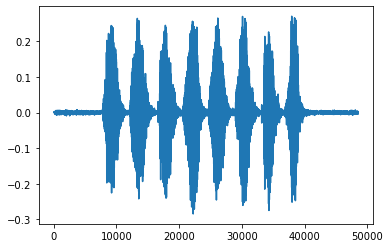

In [5]:
import matplotlib.pyplot as plt

print(data[0][0].numpy())

plt.figure()
plt.plot(waveform.t().numpy())

The first tutorial I did was relatively straightforward: I downloaded a dataset using torchaudio. Each data point in the dataset has three attributes: an array of waveform values, a sample rate, and a label indicating if the word spoken was either "yes" or "no". Then, the data is put into a data loader and transformed into tensor values, and then available to plot out the sound wave shape. This one is relatively simple, but I chose it because I was curious how pytorch worked with audio data. 

# Tutorial 2: Image classifier

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Sneaker  Sneaker  Dress  Ankle Boot


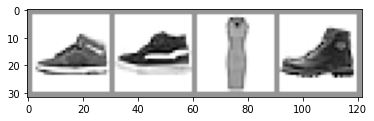

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[2.9141e-01, 6.8439e-01, 5.5371e-01, 3.5932e-01, 6.7404e-02, 9.3726e-01,
         1.8922e-01, 7.3882e-01, 2.8193e-01, 2.1887e-01],
        [1.0215e-01, 6.7070e-01, 6.7409e-01, 7.7368e-01, 3.2289e-01, 4.6152e-01,
         6.8590e-01, 8.1044e-01, 2.9723e-01, 2.8598e-01],
        [4.9146e-01, 7.7717e-01, 5.5146e-04, 8.7446e-01, 9.8979e-01, 7.4277e-01,
         1.8758e-01, 8.3219e-01, 1.7498e-01, 6.5929e-01],
        [9.7411e-01, 1.0862e-01, 6.8644e-01, 3.0453e-01, 6.2660e-01, 8.0804e-01,
         5.1877e-01, 1.7258e-01, 9.4758e-02, 6.4368e-01]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.2949299812316895


This second tutorial is a classifier for garments and clothing types. A train/test split is done initially, and we create a list for the classes/garment types. After showing a batch of the data, the model is defined using a few convolutional layers, a Max pool, and some linear layers initially. From what I have learned, this is an example of a LeNet5 network, and it's a bit more complicated than most of the models we have used thus far for image classification. Lastly, we compute cross entropy loss, which we know is best for classification tasks with > 2 classes. 